## Table of Contents

1. [Data Imports and Cleaning](#dimports)
2. [EDA](#eda)
3. [Exporting Data](#export)

#### Background

Loans provide the opportunity to link up lenders with those in need of capital. The investors make profit due to interest tacked onto the loan. However, not all loans see their principal paid until the end, and when the loan is not paid-in-full (PIF) then the loan is charged-off. When this occurs, the lender loses money and due to the chance of charge-off when it comes to personal loans, it is imperative that the platforms providing this link between lenders and borrowers have a risk model to mitigate potential charge-off based on borrower information. This study aims to train several machine learning models to classify if a borrower will repay the loan or potentially charge-off using Lending Tree data from 2007 - 2015. The guiding metric will be the area under the ROC curve (AUC), specifically the precision-recall AUC score. 
    

Possible Risks and Assumptions:

- Data comes from Kaggle and is application data, there can be missing data at random
- Both linear and non-linear relationships between variables which we can address in models
- Multicollinearity in our dependent variables due to many of them being credit-related (card utilization, accounts present)
- Data is coming from Lending Club which may have a certain limitation of scope, mainly personal loans capped at 40_000 which doesn't reflect all types of loans and loan amounts
- We would assume our observations/specific loan data are independent (can check to see if there are renewal loans...perhaps shared ID)

<a class='anchor' id='dimports'></a>
## Data Imports and Cleaning 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading in our data from Kaggle, all accepted loans from 2007 to 2018 Q4
loan = pd.read_csv('../data/accepted_2007_to_2018Q4.csv')

C:\Users\eddie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#Checking loan size
loan.shape

(2260701, 151)

We are reducing the number of features to those that will be present to an investor when presented with a loan application. This would include information such as the loan amount, term of the loan, interest rate, debt-to-income ratio, FICO score, and basic credit history. There were multiple features in the original data set for secondary applicants as there were loans for joint applications. For this study, we will solely model using individual loans and their associated applicant information. 

In [4]:
col_list = ['loan_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'total_acc', 'pub_rec', 'revol_bal', 'earliest_cr_line',
       'revol_util', 'last_fico_range_high',
       'last_fico_range_low', 'application_type', 'acc_now_delinq',
       'avg_cur_bal', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'mort_acc']

In [5]:
#Dropping all features not listed in code above
loan = loan[col_list]

In [6]:
#Setting issued date as date time
loan['issue_d'] = pd.to_datetime(loan['issue_d'])

Here, we see that the raw dataset has '2,260,701' loans, which we've reduced to 32 features, including our predicted value ('loan_status'). 

In [7]:
#Creating a function that will make a dataframe with all features, datatype, unique values, and null values
def data_summary(df):
    features = []
    dtypes = []
    unique = []
    null_values = []
    
    for c in df.columns:
        features.append(c)
        dtypes.append(df[c].dtype)
        unique.append(df[c].nunique())
        null_values.append(df[c].isna().sum())
    
    dict = {
        'feature' : features,
        'dtype' : dtypes,
        'unique_val' : unique,
        'null_values': null_values
    }
    
    data = pd.DataFrame(dict)
    return data

In [8]:
#Calling the function to look at our columns
data_summary(loan).sort_values('dtype', ascending = False)

,feature,dtype,unique_val,null_values
8,loan_status,object,9,33
5,home_ownership,object,6,33
1,term,object,2,33
23,application_type,object,2,33
9,purpose,object,14,33
19,earliest_cr_line,object,754,62
4,emp_length,object,11,146940
26,delinq_amnt,float64,2617,62
25,avg_cur_bal,float64,88597,70379
18,revol_bal,float64,102251,33


#### Setting Up Our Predicted Value

In [9]:
#Slicing our dataframe so that it only contains loans which are fully paid off or charged-off
loan = loan.loc[loan['loan_status'].isin(['Fully Paid', 'Charged Off'])]

loan['loan_status'] = loan['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

loan.loan_status.value_counts(dropna = False)

0    1076751
1     268559
Name: loan_status, dtype: int64

In [10]:
#Shape of dataset after filtering out loan_status
loan.shape

(1345310, 30)

This has reduced the number of samples we have for our model as we originally started with 2,260,701 loans. This amounts to about ~60% of our original dataset but we are not too concerned as our sample size is still significant. 

#### Cleaning Categorical Columns

In [11]:
#Print out of null values and value counts for each categorical column
for c in loan.columns:
    if loan[c].dtype == 'object':
        print(f'Feature: {c}')
        print(f'% of Null Values:{loan[c].isna().sum() / len(loan[c])}')
        print('Value Counts:')
        print(loan[c].value_counts(dropna = False))
        print('---------')

Feature: term
% of Null Values:0.0
Value Counts:
 36 months    1020743
 60 months     324567
Name: term, dtype: int64
---------
Feature: emp_length
% of Null Values:0.058359039923883714
Value Counts:
10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
NaN           78511
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: emp_length, dtype: int64
---------
Feature: home_ownership
% of Null Values:0.0
Value Counts:
MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64
---------
Feature: purpose
% of Null Values:0.0
Value Counts:
debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving           

##### Application Type

In [12]:
loan.application_type.value_counts(normalize = True)

Individual    0.980822
Joint App     0.019178
Name: application_type, dtype: float64

To start, let's remove the joint applications from our data set which we can see is a very miniscule subset of our loans. It comes out to be around 2% of all loan applications and with this major imbalance, it would benefit to remove this feature as it doesn't provide much information on joint applications. In addition to this, in terms of our initial goal, we want to build a model using only individual information to predict loan repayment.

In [13]:
loan = loan[loan.application_type == 'Individual']

##### Term

Seeing that the 'term' column has two unique values, we will convert it to a numerical feature to reduce the number of features we will have to dummify in the future.  

In [14]:
#Mapping 0 and 1 to our two respective terms
loan['term'] = loan['term'].map({
    ' 36 months': 0,
    ' 60 months': 1
})

In [15]:
#The division of loan terms in data set
loan.term.value_counts(normalize = True)

0    0.76125
1    0.23875
Name: term, dtype: float64

We can see that most loans are 3-years in term, accounting for more than 3/4 of the loans in our dataset. 

##### Employment Length


In [16]:
#Checking our value counts
loan.emp_length.value_counts(dropna = False)

10+ years    435633
2 years      119867
3 years      106015
< 1 year     102544
1 year        87271
5 years       82927
4 years       79311
NaN           74764
6 years       61920
8 years       60004
7 years       58919
9 years       50335
Name: emp_length, dtype: int64

In [17]:
emp_length_dict = {
    '< 1 year' : '<1 year',
    '1 year'   : '1-5 years',
    '2 years'  : '1-5 years',
    '3 years'  : '1-5 years',
    '4 years'  : '1-5 years',
    '5 years'  : '1-5 years',
    '6 years'  : '5-10 years',
    '7 years'  : '5-10 years',
    '8 years'  : '5-10 years',
    '9 years'  : '5-10 years',
    '10+ years': '10+ years',
    np.nan     : 'unreported'
}

loan.emp_length = loan.emp_length.map(emp_length_dict)

We can see that our employment length is split into individual years as well as there being null values. Further data exploration found that loans with 'NaN' for the employment length also shared 'NaN' values for employment title so we can deduce that loans with null employment length are those that are either unemployed, a student, retired, or possibly self-employed. Due to this, I will create a category for our unemployment length called 'unreported'. We will also group the years so that the number of features after one-hot encoding will not be too immense. 

##### Home Ownership

In [19]:
loan.home_ownership.value_counts(dropna = False)

MORTGAGE    648107
RENT        528509
OWN         142418
ANY            286
OTHER          144
NONE            46
Name: home_ownership, dtype: int64

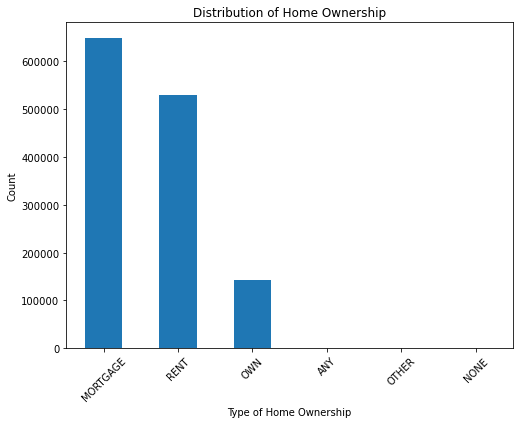

In [20]:
#Checking our distribution of home ownership
plt.figure(figsize = (8,6))
loan['home_ownership'].value_counts().plot(kind = 'bar')
plt.xlabel('Type of Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Distribution of Home Ownership');

There doesn't appear to be any null values in our loan purpose column, but it is interesting to note that the majority of loans were used for debt consolidation with small business being the runner up. 

Considering the low level of 'ANY', 'OTHER', and 'NONE', we will only include the rows including 'MORTGAGE', 'RENT', 'OWN'. To include the categories with barely any values will decrease the effectiveness of our model with needlessly complex features with barely any contribution to the model. 

In [21]:
loan = loan[(loan.home_ownership.isin(['MORTGAGE', 'RENT', 'OWN']))]

##### Earliest Credit Line - Feature Engineering

By using both the datetimes from earliest credit line and the issued loan date, we can engineer a feature that represents the credit files age. The credit file age will be the year the loan was issued minus the year they had their earliest credit line which usually indicates when someone started their credit history. We will then drop the datetime columns before we export for modeling. 

In [22]:
#Using pandas to create date time columns we can use to create 'credit_file_age'
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])
loan['earliest_cr_line_year'] = loan['earliest_cr_line'].dt.year
loan['year'] = loan['issue_d'].dt.year
loan['credit_file_age'] = loan['year'] - loan['earliest_cr_line_year']

In [23]:
loan.drop(columns = ['earliest_cr_line', 'application_type', 'year', 'earliest_cr_line_year'], inplace = True)

##### FICO

We expect FICO to be a major part in predicting whether someone will repay their loan in full or charge-off. However, this origianl dataset provides it to us in the form of a range. We will create a new column 'FICO' using the average of these two values to just capture a singular FICO value. 

In [24]:
loan['fico'] = loan[['last_fico_range_high', 'last_fico_range_low']].mean(axis = 1)

In [25]:
loan.drop(columns = ['last_fico_range_high', 'last_fico_range_low'], inplace = True)

#### Missing Values

From isolating the types of applications to 'Individual' as well as cutting down the loans in our dataset to "Fully Paid" or "Charged Off", we've reduced the number of missing values from a variety of columns. But, there still remains seven columns with missing values.

Our first strategy would be to drop all null values due to the size of our dataset which is generally not the best method of dealing with null values as we are dropping all other related features associated with a loan. 

Our second strategy would be to impute the values with a mean, median, or mode depending on the data type of the feature. Mode would be useful for categorical features, the median for discrete numerical features, and the mean for continuous numerical features -- while also accounting for outliers. 

We will first see how our initial logistic regression does on two versions of our data: one where we drop our null values, and one where we impute them with respective values. 


In [26]:
null_count = []
for columns in loan.columns[0:100]:
    if loan[columns].isna().sum() != 0:
        print('FEATURE NAME:')
        print(columns)
        print('FEATURE TYPE:')
        print(loan[columns].dtype)
        print('NULL VALUE COUNT:')
        print(loan[columns].isna().sum())
        print('PERCENT OF ALL VALUES:')
        print(loan[columns].isna().sum() / len(loan[columns]))
        print('~~~~~~~~~~~~~~~~~~~')
        null_count.append([columns, loan[columns].isna().sum(), loan[columns].isnull().mean()])
null_values = pd.DataFrame(null_count, columns = ['Feature', 'Null Value Count', 'Percentage of Data'])

FEATURE NAME:
inq_last_6mths
FEATURE TYPE:
float64
NULL VALUE COUNT:
1
PERCENT OF ALL VALUES:
7.58130571312036e-07
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
revol_util
FEATURE TYPE:
float64
NULL VALUE COUNT:
809
PERCENT OF ALL VALUES:
0.0006133276321914371
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
avg_cur_bal
FEATURE TYPE:
float64
NULL VALUE COUNT:
67444
PERCENT OF ALL VALUES:
0.05113135825156895
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
pub_rec_bankruptcies
FEATURE TYPE:
float64
NULL VALUE COUNT:
694
PERCENT OF ALL VALUES:
0.0005261426164905529
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
tax_liens
FEATURE TYPE:
float64
NULL VALUE COUNT:
37
PERCENT OF ALL VALUES:
2.805083113854533e-05
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
mort_acc
FEATURE TYPE:
float64
NULL VALUE COUNT:
47179
PERCENT OF ALL VALUES:
0.03576784222393054
~~~~~~~~~~~~~~~~~~~


In [27]:
#Filling columns with appropriate values (mode, median, mean)
loan['inq_last_6mths'].fillna(stats.mode(loan['inq_last_6mths'])[0][0], inplace = True)
loan['revol_util'].fillna(np.mean(loan['revol_util']), inplace = True)
loan['avg_cur_bal'].fillna(stats.mode(loan['avg_cur_bal'])[0][0], inplace = True)
loan['pub_rec_bankruptcies'].fillna(stats.mode(loan['pub_rec_bankruptcies'])[0][0], inplace = True)
loan['tax_liens'] = loan['tax_liens'].fillna(loan['tax_liens'].median())
loan['mort_acc'] = loan.mort_acc.fillna(loan.mort_acc.median())
loan['dti'] = loan.dti.fillna(loan.dti.mean())

In [28]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319034 entries, 0 to 2260697
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   loan_amnt             1319034 non-null  float64       
 1   term                  1319034 non-null  int64         
 2   int_rate              1319034 non-null  float64       
 3   installment           1319034 non-null  float64       
 4   emp_length            1319034 non-null  object        
 5   home_ownership        1319034 non-null  object        
 6   annual_inc            1319034 non-null  float64       
 7   issue_d               1319034 non-null  datetime64[ns]
 8   loan_status           1319034 non-null  int64         
 9   purpose               1319034 non-null  object        
 10  dti                   1319034 non-null  float64       
 11  delinq_2yrs           1319034 non-null  float64       
 12  fico_range_low        1319034 non-null  fl

## EDA <a class='anchor' id='eda'></a>

##### Loan Issue Date

In [29]:
#Creating a dataframe with loan issue date and value counts
s = loan['issue_d'].value_counts().sort_index()

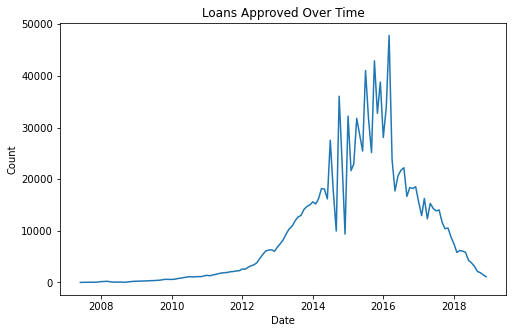

In [30]:
plt.figure(figsize = (8,5))
plt.plot(s)
plt.title('Loans Approved Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.savefig('./images/loan_over_time.png');


We can see majority of loans are from 2014 - 2016. This should assuage concerns that we may have loans from around the Great Recession which may be a different reflection of loan default risk tolerance than those more recent. Further research shows that Lending Club IPO'd in 2014 which may cause the large jump. There is also an issue with an internal auditor which caused Lending Club to have negative public perception around 2016. 

##### FICO

C:\Users\eddie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


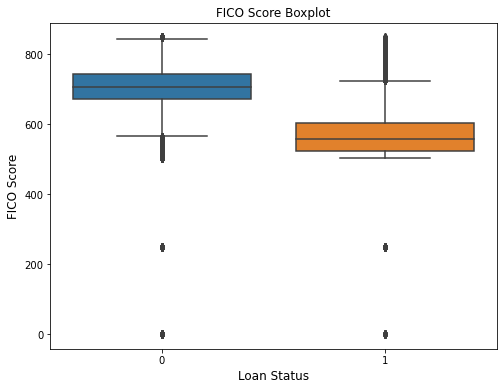

In [31]:
#Looking at our boxplot for FICO, according to Loan status
plt.figure(figsize = (8,6))
sns.boxplot(loan['loan_status'], loan['fico'])
plt.xlabel('Loan Status', size = 12)
plt.ylabel('FICO Score', size = 12)
plt.title('FICO Score Boxplot')
plt.savefig('./images/fico_boxplot.png');

In [32]:
#Per Forbes, the lowest credit score range is 300 to 579. We may look to only include those with appropriate FICO scores
loan = loan[loan['fico'] > 300]

C:\Users\eddie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


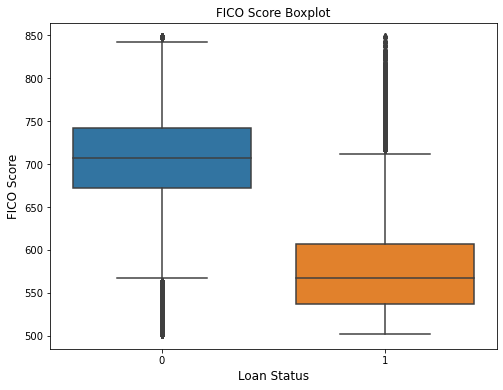

In [33]:
#Checking our box plot again
plt.figure(figsize = (8,6))
sns.boxplot(loan['loan_status'], loan['fico'])
plt.xlabel('Loan Status', size = 12)
plt.ylabel('FICO Score', size = 12)
plt.title('FICO Score Boxplot')
plt.savefig('./images/fico_boxplot.png');

In [34]:
#Dropping unnecessary columns
loan.drop(columns = ['issue_d', 'fico_range_low', 'fico_range_high'], inplace = True)

##### Annual Income

C:\Users\eddie\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution for Annual Income')

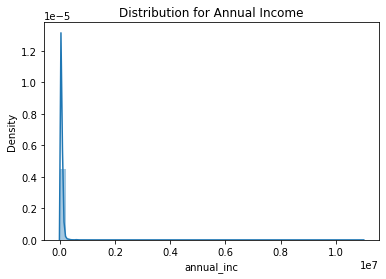

In [35]:
#Looking at distribution of Annual Income
sns.distplot(loan.annual_inc)
plt.title('Distribution for Annual Income')

It appears to be extremely right skewed, we will perform a log transformation to aid with this. 

In [36]:
#Log transform, dropped column
loan['log_annual_inc'] = np.log(loan['annual_inc'])
loan.drop(columns = ['annual_inc'], inplace = True)

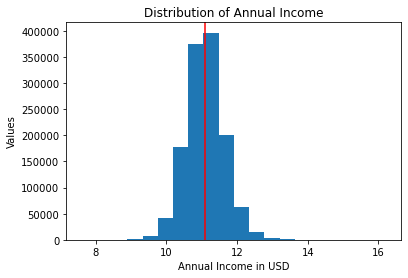

In [38]:
#Distribution more normal
plt.hist(loan.log_annual_inc, bins = 20)
plt.axvline(np.mean(loan.log_annual_inc), color = 'red')
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.xlabel('Annual Income in USD')
plt.ylabel('Values')
plt.title('Distribution of Annual Income');

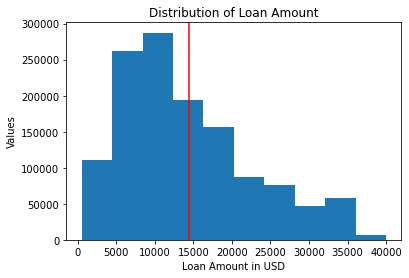

In [39]:
#Loan Amount Distribution
plt.hist(loan.loan_amnt, bins = 10)
plt.axvline(np.mean(loan.loan_amnt), color = 'red')
plt.xlabel('Loan Amount in USD')
plt.ylabel('Values')
plt.title('Distribution of Loan Amount');

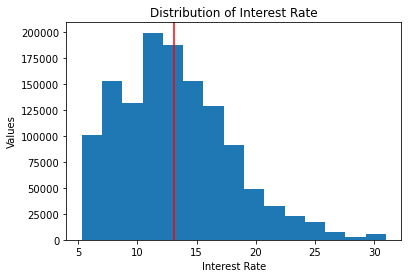

In [40]:
#Interest Rate distribution
plt.hist(loan.int_rate, bins = 15)
plt.axvline(np.mean(loan.int_rate), color = 'red')
plt.xlabel('Interest Rate')
plt.ylabel('Values')
plt.title('Distribution of Interest Rate');

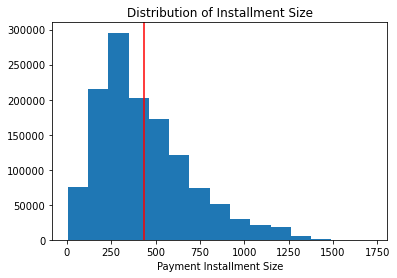

In [41]:
#Installment Size Distribution
plt.hist(loan.installment, bins = 15)
plt.axvline(np.mean(loan.installment), color = 'red')
plt.xlabel('Payment Installment Size')
plt.title('Distribution of Installment Size');

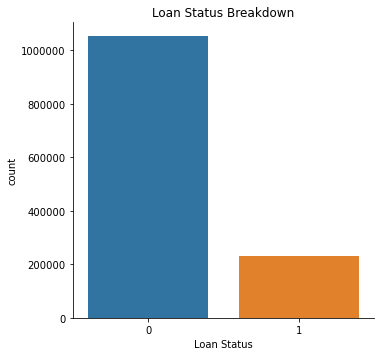

In [42]:
#Class Imbalance
sns.catplot(x = 'loan_status', kind = 'count', data = loan)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.title('Loan Status Breakdown')
plt.xlabel('Loan Status')
plt.savefig('./images/loan_status.png');

Large class imbalance we can see with our dependent variable. Loans that charged-off amount to 261,655 and loans that were fully paid amount to 1,041,952. In simple terms, there are ~4 times as many examples of loans that were fully paid off. Due to the class imbalance, we probably would not use our accuracy score considering if we guessed for all the loans to be fully paid off, we would be accurate at 79.93%. With that, we will use the precision-recall AUC score as it evaluates the faction of true positives among positive predictions.

## Exporting for Modeling <a class='anchor' id='export'></a>

In [43]:
#Resetting Index
loan.reset_index(drop = True, inplace = True)

In [44]:
#Exporting as 'loan_all'
loan.to_csv('../data/loan_all.csv', index = False)

In [ ]:
#pplot = sns.pairplot(loan.sample(1000), hue = 'loan_status', diag_kind = 'kde');
#pplot.savefig('../images/pairplot.png');